* Source : https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub?hl=ko

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 텐서플로 허브와 전이학습

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/images/transfer_learning_with_hub.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Note: 이 문서는 텐서플로 커뮤니티에서 번역했습니다. 커뮤니티 번역 활동의 특성상 정확한 번역과 최신 내용을 반영하기 위해 노력함에도
불구하고 [공식 영문 문서](https://www.tensorflow.org/?hl=en)의 내용과 일치하지 않을 수 있습니다.
이 번역에 개선할 부분이 있다면
[tensorflow/docs-l10n](https://github.com/tensorflow/docs-l10n/) 깃헙 저장소로 풀 리퀘스트를 보내주시기 바랍니다.
문서 번역이나 리뷰에 참여하려면
[docs-ko@tensorflow.org](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-ko)로
메일을 보내주시기 바랍니다.

[텐서플로 허브](http://tensorflow.org/hub)텐서플로 허브는 이 전에 학습된 모델들의 요소들을 공유하는 하나의 방법입니다. 학습된 모델들의 검색가능한 리스트에 대한 [텐서플로 모듈 허브] (https://tfhub.dev/)를 보세요. 이 튜토리얼은 입증합니다:

1. `tf.keras`로 텐서플로 허브를 사용하는 방법.
1. 텐서플로 허브를 사용하여 이미지 분류를 하는 방법.
1. 간단한 전이학습을 하는 방법.

## 설치하기


In [1]:
import matplotlib.pylab as plt

import tensorflow as tf

In [2]:
!pip install -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers

     |████████████████████████████████| 112kB 23.6MB/s 


## ImageNet 분류기


### 분류기 다운로드하기

이동 네트워크 컴퓨터를 로드하기 위해 `hub.module`을, 그리고 하나의 keras층으로 감싸기 위해 `tf.keras.layers.Lambda`를 사용하세요. Fthub.dev의 [텐서플로2.0 버전의 양립 가능한 이미지 분류기 URL](https://tfhub.dev/s?q=tf2&module-type=image-classification) 는 이곳에서 작동할 것입니다.

In [3]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}

In [4]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

### 싱글 이미지 실행시키기


모델을 시도하기 위해 싱글 이미지를 다운로드하세요.

65536/61306 [================================] - 0s 0us/step


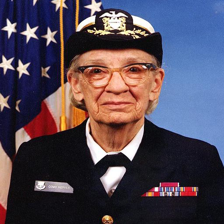

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

차원 배치를 추가하세요, 그리고 이미지를 모델에 통과시키세요.

In [7]:
result = classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

그 결과는 로지트의 1001 요소 벡터입니다. 이는 이미지에 대한 각각의 클래스 확률을 계산합니다.

그래서 탑 클래스인 ID는 최대값을 알 수 있습니다:

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

### 예측 해독하기

우리는 클래스 ID를 예측하고,
`ImageNet`라벨을 불러오고, 그리고 예측을 해독합니다.

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


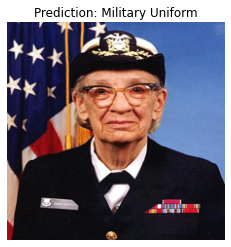

In [10]:
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

## 간단한 전이 학습


텐서플로 허브를 사용함으로써, 우리의 데이터셋에 있는 클래스들을 인지하기 위해 모델의 최상위 층을 재학습 시키는 것이 쉬워졌습니다.

### 데이터셋

 이 예제를 해결하기 위해, 텐서플로의 flowers 데이터셋을 사용할 것입니다:

In [11]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 1s 0us/step


우리의 모델에 이 데이터를 가장 간단하게 로딩 하는 방법은 `tf.keras.preprocessing.image.image.ImageDataGenerator`를 사용하는 것이고,

모든 텐서플로 허브의 이미지 모듈들은 0과 1사이의 상수들의 입력을 기대합니다. 이를 만족 시키기 위해 `ImageDataGenerator`의 `rescale`인자를 사용하세요.

그 이미지의 사이즈는 나중에 다뤄질 것입니다.

In [12]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


결과로 나온 오브젝트는 `image_batch`와 `label_batch`를 같이 리턴 하는 반복자입니다.

In [13]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


### 이미지 배치에 대한 분류기를 실행해보자


이제 이미지 배치에 대한 분류기를 실행해봅시다.

In [14]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [15]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['pot', 'daisy', 'daisy', 'honeycomb', 'bee', 'daisy',
       'picket fence', 'daisy', 'daisy', 'orange', 'velvet', 'ringlet',
       'bell pepper', 'bell pepper', 'plastic bag', 'vase', 'hair slide',
       'daisy', 'hummingbird', 'daisy', 'daisy', 'horse cart',
       'sea urchin', 'hip', 'picket fence', 'sea urchin', 'daisy', 'bee',
       'daisy', 'hip', 'picket fence', 'daisy'], dtype='<U30')

얼마나 많은 예측들이 이미지에 맞는지 검토해봅시다:

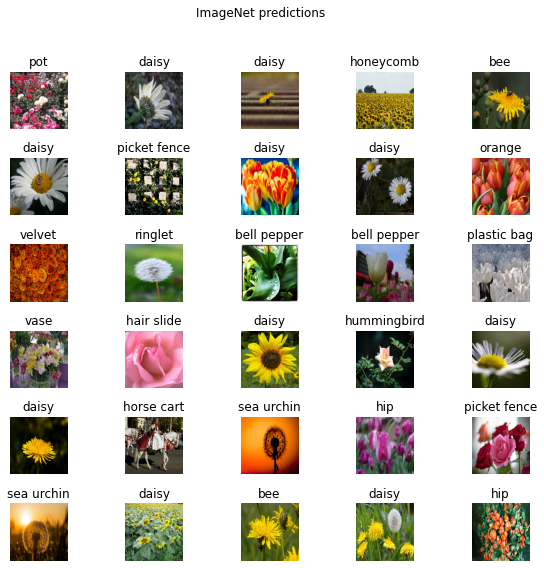

In [16]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

이미지 속성을 가진 `LICENSE.txt` 파일을 보세요.

결과가 완벽과는 거리가 멀지만, 모델이 ("daisy"를 제외한) 모든 것을 대비해서 학습된 클래스가 아니라는 것을 고려하면 합리적입니다.

### 헤드리스 모델을 다운로드하세요

텐서플로 허브는 맨 위 분류층이 없어도 모델을 분배 시킬 수 있습니다. 이는 전이 학습을 쉽게 할 수 있게 만들었습니다.

fthub.dev의 [텐서플로 2.0버전의 양립 가능한 이미지 특성 벡터 URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) 은 모두 이 곳에서 작동할 것입니다.

In [17]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}

특성 추출기를 만들어봅시다.

In [18]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))

이 것은 각각의 이미지마다 길이가 1280인 벡터가 반환됩니다:

In [19]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


특성 추출기 계층에 있는 변수들을 굳히면, 학습은 오직 새로운 분류 계층만 변경시킬 수 있습니다.

In [20]:
feature_extractor_layer.trainable = False

### 분류 head를 붙이세요.

이제 `tf.keras.Sequential` 모델에 있는 허브 계층을 포장하고, 새로운 분류 계층을 추가하세요.

In [21]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
predictions = model(image_batch)

In [23]:
predictions.shape

TensorShape([32, 5])

### 모델을 학습시키세요

학습 과정 환경을 설정하기 위해 컴파일을 사용하세요:

In [24]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

이제 모델을 학습시키기 위해 `.fit`방법을 사용하세요.

예제를 짧게 유지시키기 위해 오로지 2세대만 학습시키세요. 학습 과정을 시각화하기 위해서, 맞춤형 회신을 사용하면 손실과, 세대 평균이 아닌 배치 개별의 정확도를 기록할 수 있습니다.

In [25]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [26]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
115/115 [==============================] - 13s 114ms/step - loss: 0.2582 - acc: 0.9375
Epoch 2/2
115/115 [==============================] - 13s 113ms/step - loss: 0.2508 - acc: 0.9375


지금부터, 단순한 학습 반복이지만, 우리는 항상 모델이 프로세스를 만드는 중이라는 것을 알 수 있습니다.

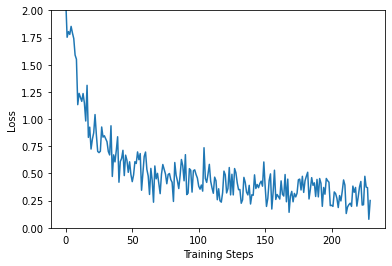

In [27]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

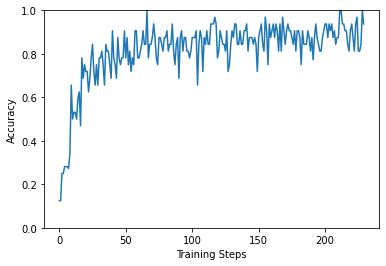

In [28]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

### 예측을 확인하세요

이 전의 계획을 다시하기 위해서, 클래스 이름들의 정렬된 리스트를 첫번째로 얻으세요:

In [29]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

모델을 통해 이미지 배치를 실행시키세요. 그리고 인덱스들을 클래스 이름으로 바꾸세요.

In [30]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

결과를 계획하세요

In [31]:
label_id = np.argmax(label_batch, axis=-1)

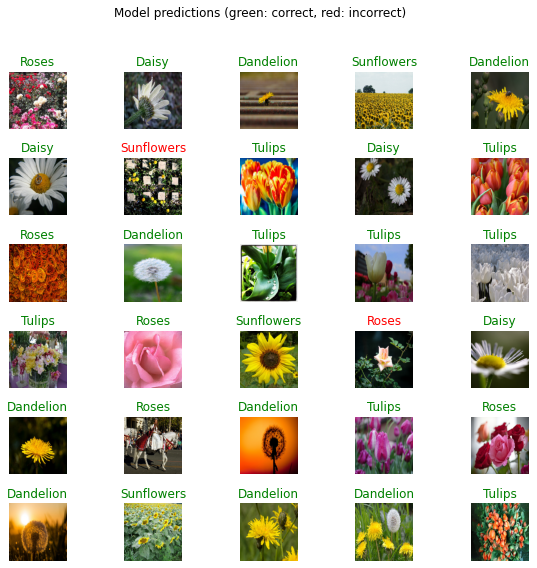

In [32]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

## 당신의 모델을 내보내세요

당신은 모델을 학습시켜왔기 때문에, 저장된 모델을 내보내세요:

In [33]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/saved_models/1606884100/assets


'/tmp/saved_models/1606884100'

이제 우리는 그것을 새롭게 로딩 할 수 있고, 이는 같은 결과를 줄 것입니다:

In [34]:
reloaded = tf.keras.models.load_model(export_path)

In [35]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [36]:
abs(reloaded_result_batch - result_batch).max()

0.0

저장된 모델은 추후에 추론을 할 수도 있고, [TFLite](https://www.tensorflow.org/lite/convert/) 나 [TFjs](https://github.com/tensorflow/tfjs-converter) 로 변환할 수 있습니다.
